Importing Libraries


In [1]:
import csv
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import norm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy import stats
from collections import Counter
import torch

Loading Dataset


In [ ]:
fashion_mnist = fetch_openml(data_id=40996,as_frame=False,parser="auto")
fashion_mnist.data.shape

(70000, 784)

In [ ]:
# 0 T-shirt/top
# 1 Trouser
# 2 Pullover
# 3 Dress
# 4 Coat
# 5 Sandal
# 6 Shirt
# 7 Sneaker
# 8 Bag
# 9 Ankle boot

Preprocessing Data

In [ ]:
X = fashion_mnist.data.astype('float32')
y = fashion_mnist.target.astype('int64')
# noise = np.random.normal(0, 0.1, X.shape)
# X_noise = X + noise
# noisy_array = np.clip(noisy_array, 0, 1)

In [ ]:
def plot_example(X, y,k=5):
    """Plot the first 5 images and their labels in a row."""
    plt.figure(figsize=(10,6))
    for i, (img, y) in enumerate(zip(X[:k].reshape(k, 28, 28), y[:k])):
        plt.subplot(1,k,1+i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

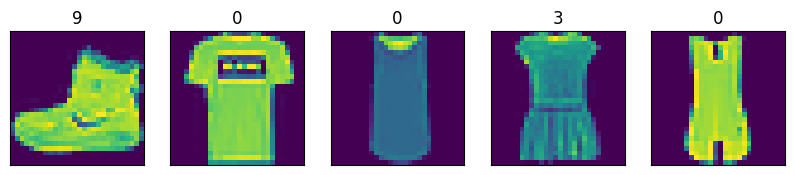

In [ ]:
plot_example(X, y)

Split Data

In [ ]:
X_splits = {}
y_splits = {}
unique_labels = np.unique(y)
for label in unique_labels:
    X_splits[label] = X[y == label]
    y_splits[label] = y[y == label]


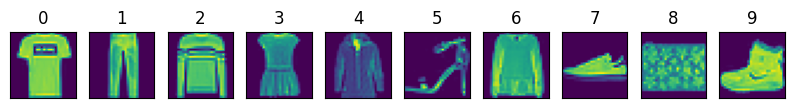

In [ ]:
sample_X = []
sample_y = []
for i in range(10):
    sample_X.append(X_splits[i][0])
    sample_y.append(y_splits[i][0])
sample_X = np.array(sample_X)
sample_y = np.array(sample_y)
plot_example(sample_X,sample_y,k=10)

In [ ]:
X_26 = np.concatenate((X_splits[2],X_splits[6]),axis=0)
y_26 = np.concatenate((y_splits[2],y_splits[6]))

In [ ]:
print(X_26.shape,y_26.shape)

(14000, 784) (14000,)


In [ ]:
y_26_oh = y_26.copy()
y_26_oh[y_26_oh == 2] = 1
y_26_oh[y_26_oh == 6] = 0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_26,y_26_oh, test_size=0.20, random_state=42,shuffle=True)

In [ ]:
np.unique(y_train,return_counts=True)

(array([0, 1]), array([5615, 5585]))

In [ ]:
np.unique(y_test,return_counts=True)

(array([0, 1]), array([1385, 1415]))

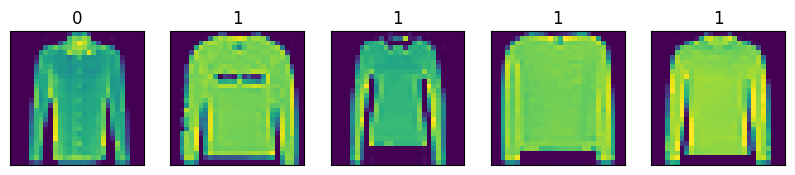

In [ ]:
plot_example(X_train, y_train)

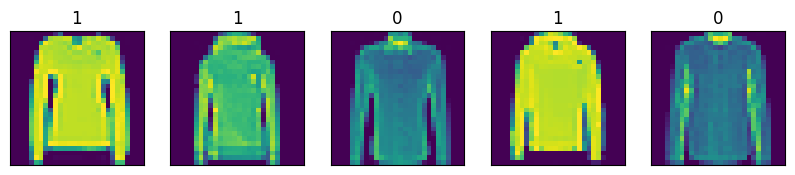

In [ ]:
plot_example(X_test, y_test)

In [ ]:

def write_to_csv(data,csv_file_path):
    # Check if the CSV file exists
    if os.path.exists(csv_file_path):
        # Read the existing data from the CSV file
        existing_data = pd.read_csv(csv_file_path, header=None).values.tolist()
    else:
        existing_data = []

    # Transpose the data to write it in columns
    data = [data]  # Convert data into a list of lists
    data = list(map(list, zip(*data)))  # Transpose the data

    # Append the new data to the existing data
    if existing_data:
        for i in range(min(len(existing_data), len(data))):
            existing_data[i].extend(data[i])
    else:
        existing_data = data

    # Write the combined data to the CSV file
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the data to the CSV file column-wise
        for row in existing_data:
            writer.writerow(row)

In [ ]:
def sampling(n,input,output,replace=False):
    indices = np.random.choice(len(input),n,replace=replace)
    bootstrap_X = X_train[indices]
    bootstrap_y = y_train[indices]
    return bootstrap_X,bootstrap_y

pi = tf.constant(tf.constant(np.pi), dtype=tf.float32)
epsilon = 1e-7



def create_model(activation="sigmoid",variance=0,gamma=1):
    model = keras.Sequential()
    model.add(layers.Input(shape=(784,)))
    model.add(layers.Dense(64, activation='relu'))
    if activation == "sigmoid":
        model.add(layers.Dense(1, activation='sigmoid'))
    elif activation == "tanh":
        model.add(layers.Dense(1, activation='tanh'))
        model.add(keras.layers.Lambda(lambda x: (x + 1.0) / 2))
    elif activation == "normal_cdf":
        def cdf_normal(x):
            return (0.5) * (tf.math.erf(x /(variance* tf.sqrt(2.0)))) + 0.5
        normal_activation_layer = keras.layers.Activation(cdf_normal)
        model.add(keras.layers.Dense(1, activation=normal_activation_layer))
    else:
        def cdf_cauchy(x):
            return 0.5 + tf.math.atan(x/gamma) /pi
        cauchy_activation_layer = keras.layers.Activation(cdf_cauchy)
        model.add(keras.layers.Dense(1, activation=cauchy_activation_layer))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


def create_table(model,input,output):
    pred = model.predict(input)
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    # Calculate confusion matrix values
    for i in range(len(pred)):
        if output[i] == 1 and pred[i] == 1:
            true_positives += 1
        elif output[i] == 0 and pred[i] == 0:
            true_negatives += 1
        elif output[i] == 0 and pred[i] == 1:
            false_positives += 1
        elif output[i] == 1 and pred[i] == 0:
            false_negatives += 1

    # Create the confusion matrix as a list of lists
    confusion_matrix_result = [[true_negatives, false_positives],
                            [false_negatives, true_positives]]

    # Convert the confusion matrix to a numpy array for better visualization (optional)
    confusion_matrix_array = np.array(confusion_matrix_result)
    return confusion_matrix_array

def joint_odds_ratio(tables):
    k = len(tables)
    num = 0
    den = 0
    for i in range(k):
        sum = tables[i][0][0] + tables[i][0][1] + tables[i][1][1] + tables[i][1][0]
        num = num + (tables[i][0][0]*tables[i][1][1])/sum
        den = den + (tables[i][0][1]*tables[i][1][0])/sum
    return num/den

def odds_ratio(table):
    pA = table[0][0]/(table[0][0]+table[1][0])
    pB = table[0][1]/(table[0][1]+table[1][1])
    return (pA*(1-pB))/(pB*(1-pA))

In [ ]:
model_cauchy = create_model("cauchy_cdf",gamma=1)
model_cauchy.fit(X_train[:],y_train[:],epochs=10)

Epoch 1/10
350/350 [==============================] - 2s 3ms/step - loss: 1.6812 - accuracy: 0.7113
Epoch 2/10
350/350 [==============================] - 1s 3ms/step - loss: 1.2007 - accuracy: 0.7956
Epoch 3/10
350/350 [==============================] - 1s 3ms/step - loss: 1.1423 - accuracy: 0.8062
Epoch 4/10
350/350 [==============================] - 1s 3ms/step - loss: 0.9288 - accuracy: 0.8276
Epoch 5/10
350/350 [==============================] - 1s 3ms/step - loss: 0.7686 - accuracy: 0.8432
Epoch 6/10
350/350 [==============================] - 1s 4ms/step - loss: 0.6815 - accuracy: 0.8514
Epoch 7/10
350/350 [==============================] - 1s 4ms/step - loss: 0.6257 - accuracy: 0.8557
Epoch 8/10
350/350 [==============================] - 1s 4ms/step - loss: 0.4892 - accuracy: 0.8387
Epoch 9/10
350/350 [==============================] - 1s 4ms/step - loss: 0.3752 - accuracy: 0.8450
Epoch 10/10
350/350 [==============================] - 1s 3ms/step - loss: 0.3822 - accuracy: 0.8361

In [ ]:
y_pred = (model_cauchy.predict(X_test)>0.5)
accuracy_score(y_test, y_pred)

88/88 [==============================] - 0s 2ms/step


0.8410714285714286

In [ ]:
import time
n_ensembles = 100
ensemble_odds_ratio_train = []
ensemble_odds_ratio_test = []
for v in range(n_ensembles):
    # Start timing the training process
    start_time = time.time()
    k = 10
    n = 5000
    models = []
    models.append(create_model("sigmoid"))
    models.append(create_model("sigmoid"))
    models.append(create_model("normal_cdf",variance=20))
    models.append(create_model("normal_cdf",variance=20))
    models.append(create_model("normal_cdf",variance=40))
    models.append(create_model("normal_cdf",variance=40))
    models.append(create_model("cauchy_cdf",gamma=1))
    models.append(create_model("cauchy_cdf",gamma=2))
    models.append(create_model("cauchy_cdf",gamma=1))
    models.append(create_model("cauchy_cdf",gamma=2))
    train_tables = []
    test_tables = []
    for i in range(k):
        sampled_X,sampled_y = sampling(n,X_train,y_train,replace=True)
        # with tf.device('/GPU:0'):
        models[i].fit(sampled_X, sampled_y, epochs=10, verbose = 0)

        train_tables.append(create_table(models[i],sampled_X,sampled_y))
        # print(train_tables[-1])
        test_tables.append(create_table(models[i],X_test,y_test))
    ensemble_odds_ratio_train.append(joint_odds_ratio(train_tables))
    ensemble_odds_ratio_test.append(joint_odds_ratio(test_tables))

    # End timing
    end_time = time.time()
    print(v, " : ", end_time-start_time)

88/88 [==============================] - 1s 6ms/step
0  :  64.81159019470215
88/88 [==============================] - 0s 2ms/step
1  :  67.07214403152466
88/88 [==============================] - 0s 2ms/step
2  :  66.48570466041565
88/88 [==============================] - 0s 3ms/step
3  :  64.08909678459167
88/88 [==============================] - 0s 2ms/step
4  :  70.83439040184021
88/88 [==============================] - 0s 2ms/step
5  :  65.53220915794373
88/88 [==============================] - 0s 2ms/step
6  :  69.86295175552368
88/88 [==============================] - 0s 2ms/step
7  :  61.4350905418396
88/88 [==============================] - 0s 2ms/step
8  :  65.82625150680542
88/88 [==============================] - 0s 2ms/step
9  :  68.13936471939087
88/88 [==============================] - 0s 2ms/step
10  :  66.3278911113739
88/88 [==============================] - 0s 2ms/step
11  :  58.06167459487915
88/88 [==============================] - 0s 2ms/step
12  :  67.5881669521331

In [2]:
train_csv_file_path = "/content/drive/MyDrive/MTP/Fashion_Mnist/Fashion_MNIST_Train_Odds_Ratio_different_activations.csv"
test_csv_file_path = "/content/drive/MyDrive/MTP/Fashion_Mnist/Fashion_MNIST_Test_Odds_Ratio_different_activations.csv"

In [ ]:
write_to_csv(ensemble_odds_ratio_train,train_csv_file_path)
write_to_csv(ensemble_odds_ratio_test,test_csv_file_path)

In [3]:
train_df = pd.read_csv(train_csv_file_path)
test_df = pd.read_csv(test_csv_file_path)
ensemble_odds_ratio_train = train_df.values.ravel().tolist()
ensemble_odds_ratio_test = test_df.values.ravel().tolist()
ensemble_odds_ratio_train += [float(value) for value in train_df.columns.values.tolist()]
ensemble_odds_ratio_test += [float(value) for value in test_df.columns.values.tolist()]

In [4]:
print(len(ensemble_odds_ratio_train))
print(len(ensemble_odds_ratio_test))

1000
1000


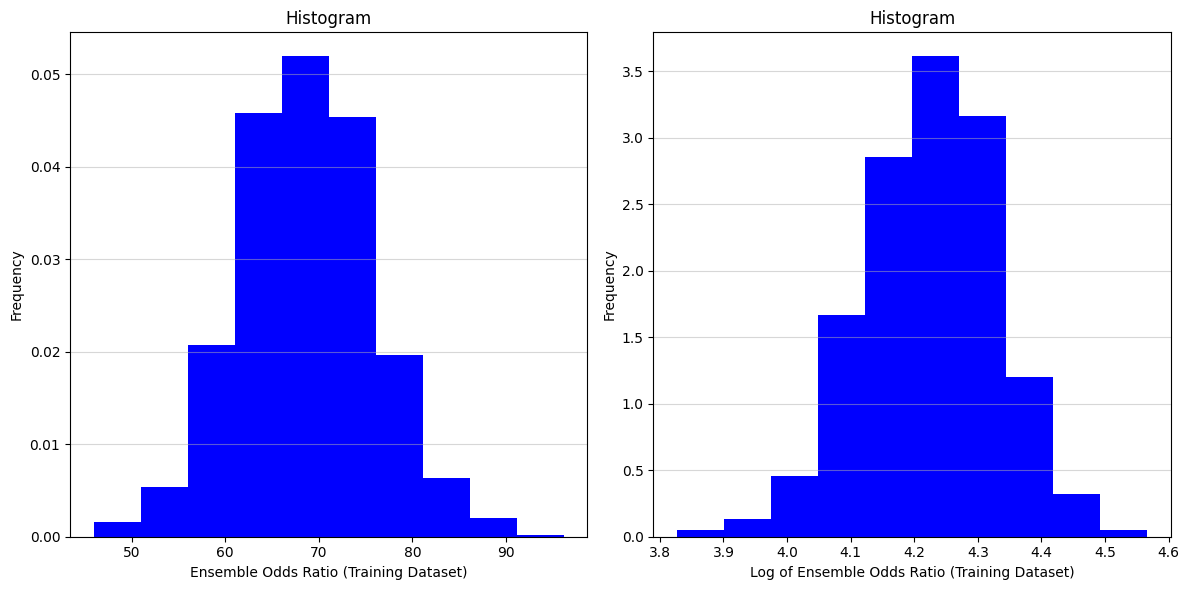

In [5]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot a histogram
axes[0].hist(ensemble_odds_ratio_train, density=True, color='b')
axes[0].set_xlabel('Ensemble Odds Ratio (Training Dataset)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram')
axes[0].grid(axis='y', alpha=0.5)

axes[1].hist(np.log(ensemble_odds_ratio_train), density=True, color='b')
axes[1].set_xlabel('Log of Ensemble Odds Ratio (Training Dataset)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram')
axes[1].grid(axis='y', alpha=0.5)

# Plot a KDE plot
# sns.kdeplot(np.log(ensemble_odds_ratio_train), fill=True, ax=axes[1])
# axes[1].set_xlabel('Ensemble Odds Ratio')
# axes[1].set_ylabel('Density')
# axes[1].set_title('KDE Plot')
# axes[1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

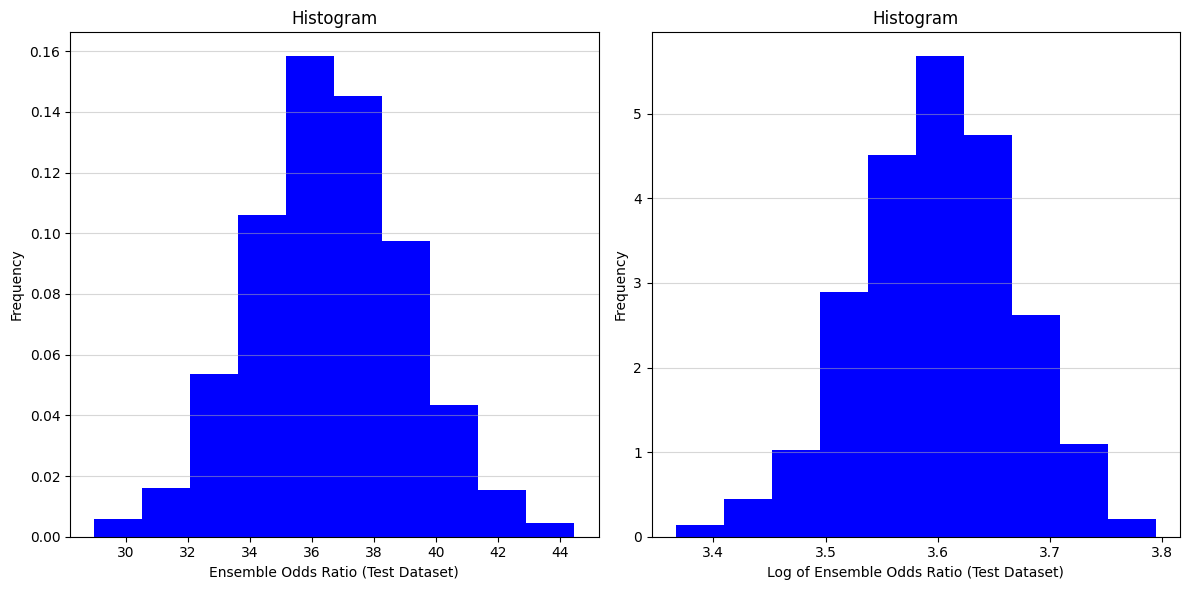

In [6]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot a histogram
axes[0].hist(ensemble_odds_ratio_test, density=True, color='b')
axes[0].set_xlabel('Ensemble Odds Ratio (Test Dataset)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram')
axes[0].grid(axis='y', alpha=0.5)

axes[1].hist(np.log(ensemble_odds_ratio_test), density=True, color='b')
axes[1].set_xlabel('Log of Ensemble Odds Ratio (Test Dataset)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram')
axes[1].grid(axis='y', alpha=0.5)

# Plot a KDE plot
# sns.kdeplot(np.log(ensemble_odds_ratio_train), fill=True, ax=axes[1])
# axes[1].set_xlabel('Ensemble Odds Ratio')
# axes[1].set_ylabel('Density')
# axes[1].set_title('KDE Plot')
# axes[1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

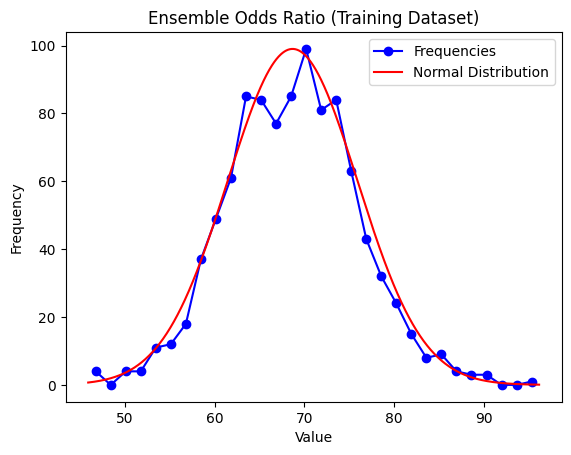

        Mean: 68.69235525398247
        Variance: 52.42451918744929


In [17]:
data = ensemble_odds_ratio_train
hist, bins = np.histogram(data,bins=30)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, hist, marker='o', linestyle='-', color='b', label='Frequencies')
mean = np.mean(data)
variance = np.var(data)
x = np.linspace(min(data), max(data), 1000)
normal_curve = norm.pdf(x, mean, np.sqrt(variance))
area_under_hist = np.max(hist)
area_under_normal = np.max(normal_curve)
normal_curve *= (area_under_hist/area_under_normal)

plt.plot(x, normal_curve, 'r-', label='Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Ensemble Odds Ratio (Training Dataset)')
plt.legend()
plt.show()
print("        Mean:", mean)
print("        Variance:", variance)

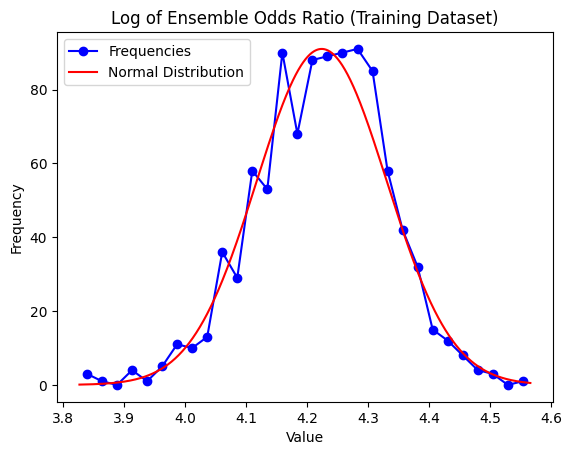

       Mean: 4.224015182715562
       Variance: 0.011351226071910905


In [21]:
data = np.log(ensemble_odds_ratio_train)
hist, bins = np.histogram(data,bins=30)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, hist, marker='o', linestyle='-', color='b', label='Frequencies')
mean = np.mean(data)
variance = np.var(data)
x = np.linspace(min(data), max(data), 1000)
normal_curve = norm.pdf(x, mean, np.sqrt(variance))
area_under_hist = np.max(hist)
area_under_normal = np.max(normal_curve)
normal_curve *= (area_under_hist/area_under_normal)

plt.plot(x, normal_curve, 'r-', label='Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Log of Ensemble Odds Ratio (Training Dataset)')
plt.legend()
plt.show()
print("       Mean:", mean)
print("       Variance:", variance)

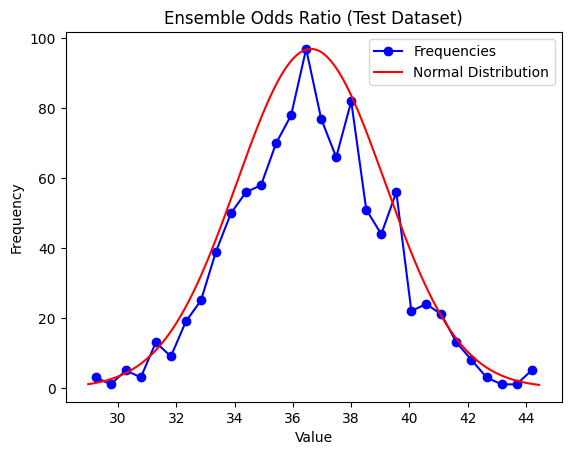

        Mean: 36.623401608213136
        Variance: 6.453628735720347


In [19]:
data = ensemble_odds_ratio_test
hist, bins = np.histogram(data,bins=30)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, hist, marker='o', linestyle='-', color='b', label='Frequencies')
mean = np.mean(data)
variance = np.var(data)
x = np.linspace(min(data), max(data), 1000)
normal_curve = norm.pdf(x, mean, np.sqrt(variance))
area_under_hist = np.max(hist)
area_under_normal = np.max(normal_curve)
normal_curve *= (area_under_hist/area_under_normal)

plt.plot(x, normal_curve, 'r-', label='Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Ensemble Odds Ratio (Test Dataset)')
plt.legend()
plt.show()
print("        Mean:", mean)
print("        Variance:", variance)

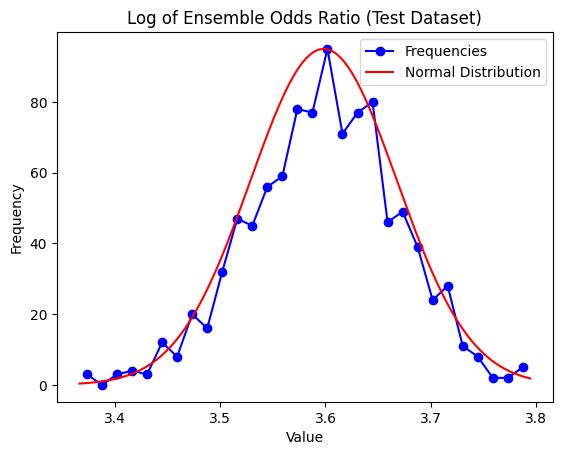

       Mean: 3.598267892002831
       Variance: 0.0048588024502631035


In [22]:
# Calculate the frequency of each value
data = np.log(ensemble_odds_ratio_test)

# Calculate the histogram with 30 bins
hist, bins = np.histogram(data,bins=30)

# Calculate the bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the frequencies
plt.plot(bin_centers, hist, marker='o', linestyle='-', color='b', label='Frequencies')

# Calculate mean and variance
mean = np.mean(data)
variance = np.var(data)

# Generate the normal distribution curve
x = np.linspace(min(data), max(data), 1000)
normal_curve = norm.pdf(x, mean, np.sqrt(variance))

# Normalize the normal curve to match the frequency scale
area_under_hist = np.max(hist)
area_under_normal = np.max(normal_curve)
normal_curve *= (area_under_hist/area_under_normal)

# Plot the normal distribution
plt.plot(x, normal_curve, 'r-', label='Normal Distribution')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Log of Ensemble Odds Ratio (Test Dataset)')
plt.legend()
plt.show()

print("       Mean:", mean)
print("       Variance:", variance)

In [11]:
ks_statistic, p_value = ks_2samp(np.log(ensemble_odds_ratio_train), np.log(ensemble_odds_ratio_test))

In [12]:
ks_statistic

1.0

In [13]:
p_value

0.0

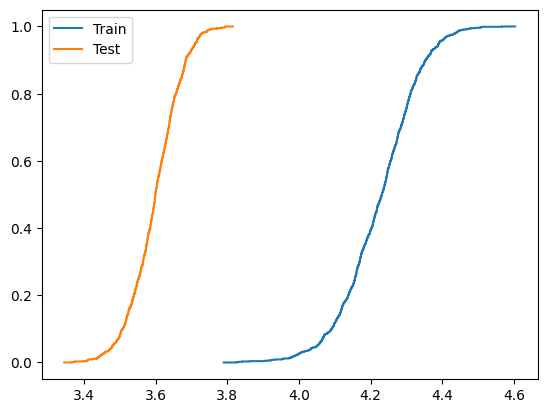

In [14]:
res_train = stats.ecdf(np.log(ensemble_odds_ratio_train))
ax = plt.subplot()
res_train.cdf.plot(ax)
res_test = stats.ecdf(np.log(ensemble_odds_ratio_test))
res_test.cdf.plot(ax)
ax.legend(['Train','Test'])
plt.show()